# Transpiling against unique devices

One of the more powerful features of Qiskit is the ability to support unique device configurations.  We can create unique `BackendV2` objects with different geometries or basis gates and transpile your circuits with those configurations in mind.  As an example, let's consider a backend with a disjoint qubit lattice whose basis gates are different along the edges than within the bulk.

To start, first create a new class which extends `BackendV2`.  We'll add in 

In [13]:
import numpy as np
import rustworkx as rx

from qiskit.providers import BackendV2, Options
from qiskit.transpiler import Target, InstructionProperties
from qiskit.circuit.library import XGate, SXGate, RZGate, CZGate, ECRGate
from qiskit.circuit import Measure, Delay, Parameter, IfElseOp, Reset



class FakeLOCCBackend(BackendV2):
    """Fake multi chip backend."""

    def __init__(self, distance=3, number_of_chips=3):
        """Instantiate a new fake multi chip backend.

        Args:
            distance (int): The heavy hex code distance to use for each chips'
                coupling map. This number **must** be odd. The distance relates
                to the number of qubits by:
                :math:`n = \\frac{5d^2 - 2d - 1}{2}` where :math:`n` is the
                number of qubits and :math:`d` is the ``distance``
            number_of_chips (int): The number of chips to have in the multichip backend
                each chip will be a heavy hex graph of ``distance`` code distance.
        """
        super().__init__(name='Fake LOCC backend')
        graph = rx.generators.directed_heavy_hex_graph(distance, bidirectional=False)
        num_qubits = len(graph) * number_of_chips
        rng = np.random.default_rng(seed=12345678942)
        rz_props = {}
        x_props = {}
        sx_props = {}
        measure_props = {}
        delay_props = {}
        self._target = Target("Fake multi-chip backend", num_qubits=num_qubits)
        # Add 1q gates. Globally use virtual rz, x, sx, and measure
        for i in range(num_qubits):
            qarg = (i,)
            rz_props[qarg] = InstructionProperties(error=0.0, duration=0.0)
            x_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            sx_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-6, 1e-4), duration=rng.uniform(1e-8, 9e-7)
            )
            measure_props[qarg] = InstructionProperties(
                error=rng.uniform(1e-3, 1e-1), duration=rng.uniform(1e-8, 9e-7)
            )
            delay_props[qarg] = None
        self._target.add_instruction(XGate(), x_props)
        self._target.add_instruction(SXGate(), sx_props)
        self._target.add_instruction(RZGate(Parameter("theta")), rz_props)
        self._target.add_instruction(Measure(), measure_props)
        self._target.add_instruction(Reset(), measure_props)

        self._target.add_instruction(Delay(Parameter("t")), delay_props)
        # Add chip local 2q gate which is cz
        cz_props = {}
        for i in range(number_of_chips):
            for root_edge in graph.edge_list():
                offset = i * len(graph)
                edge = (root_edge[0] + offset, root_edge[1] + offset)
                cz_props[edge] = InstructionProperties(
                    error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
                )
        self._target.add_instruction(CZGate(), cz_props)
        print(cz_props)
        cx_props = {}
        # Add interchip 2q gates which are ecr
        # First determine which nodes to connect
        node_indices = graph.node_indices()
        edge_list = graph.edge_list()
        inter_chip_nodes = {}
        for node in node_indices:
            count = 0
            for edge in edge_list:
                if node == edge[0]:
                    count+=1
            if count == 1:
                inter_chip_nodes[node] = count
        # Create inter-chip ecr props
        cx_props = {}
        inter_chip_edges = list(inter_chip_nodes.keys())
        for i in range(1, number_of_chips):
            offset = i * len(graph)
            edge = (inter_chip_edges[1] + (len(graph) * (i-1)) , inter_chip_edges[0] + offset)
            cx_props[edge] = InstructionProperties(
                error=rng.uniform(7e-4, 5e-3), duration=rng.uniform(1e-8, 9e-7)
            )
        self._target.add_instruction(ECRGate(), cx_props)
                
            
        
        

        
        

    @property
    def target(self):
        return self._target

    @property
    def max_circuits(self):
        return None

    @classmethod
    def _default_options(cls):
        return Options(shots=1024)

    def run(self, circuit, **kwargs):
        raise NotImplementedError("Lasciate ogne speranza, voi ch'intrate")

In [16]:
import os

from qiskit.visualization import plot_gate_map

# Generate a backend with 3x 883 qubit heavy-hex chips (2649 qubits total):
backend = FakeLOCCBackend(3, 3)
target = backend.target


coupling_map = target.build_coupling_map()
print(coupling_map)


{(0, 13): InstructionProperties(duration=7.72025785803178e-07, error=0.0013845522559138412, calibration=None), (1, 13): InstructionProperties(duration=8.948060744698759e-07, error=0.003929565382478193, calibration=None), (1, 14): InstructionProperties(duration=8.404704788497909e-07, error=0.0019384961408255063, calibration=None), (2, 14): InstructionProperties(duration=2.75850139146414e-07, error=0.0034921719606312695, calibration=None), (3, 15): InstructionProperties(duration=3.3134287332586024e-07, error=0.0011911405223384674, calibration=None), (4, 15): InstructionProperties(duration=8.125507701465912e-07, error=0.0008247769786361025, calibration=None), (4, 16): InstructionProperties(duration=8.425567585456959e-07, error=0.0018623841613246567, calibration=None), (5, 16): InstructionProperties(duration=1.2420622295255902e-07, error=0.001987339318457564, calibration=None), (6, 17): InstructionProperties(duration=2.439654245328859e-07, error=0.0007233736994638291, calibration=None), (7

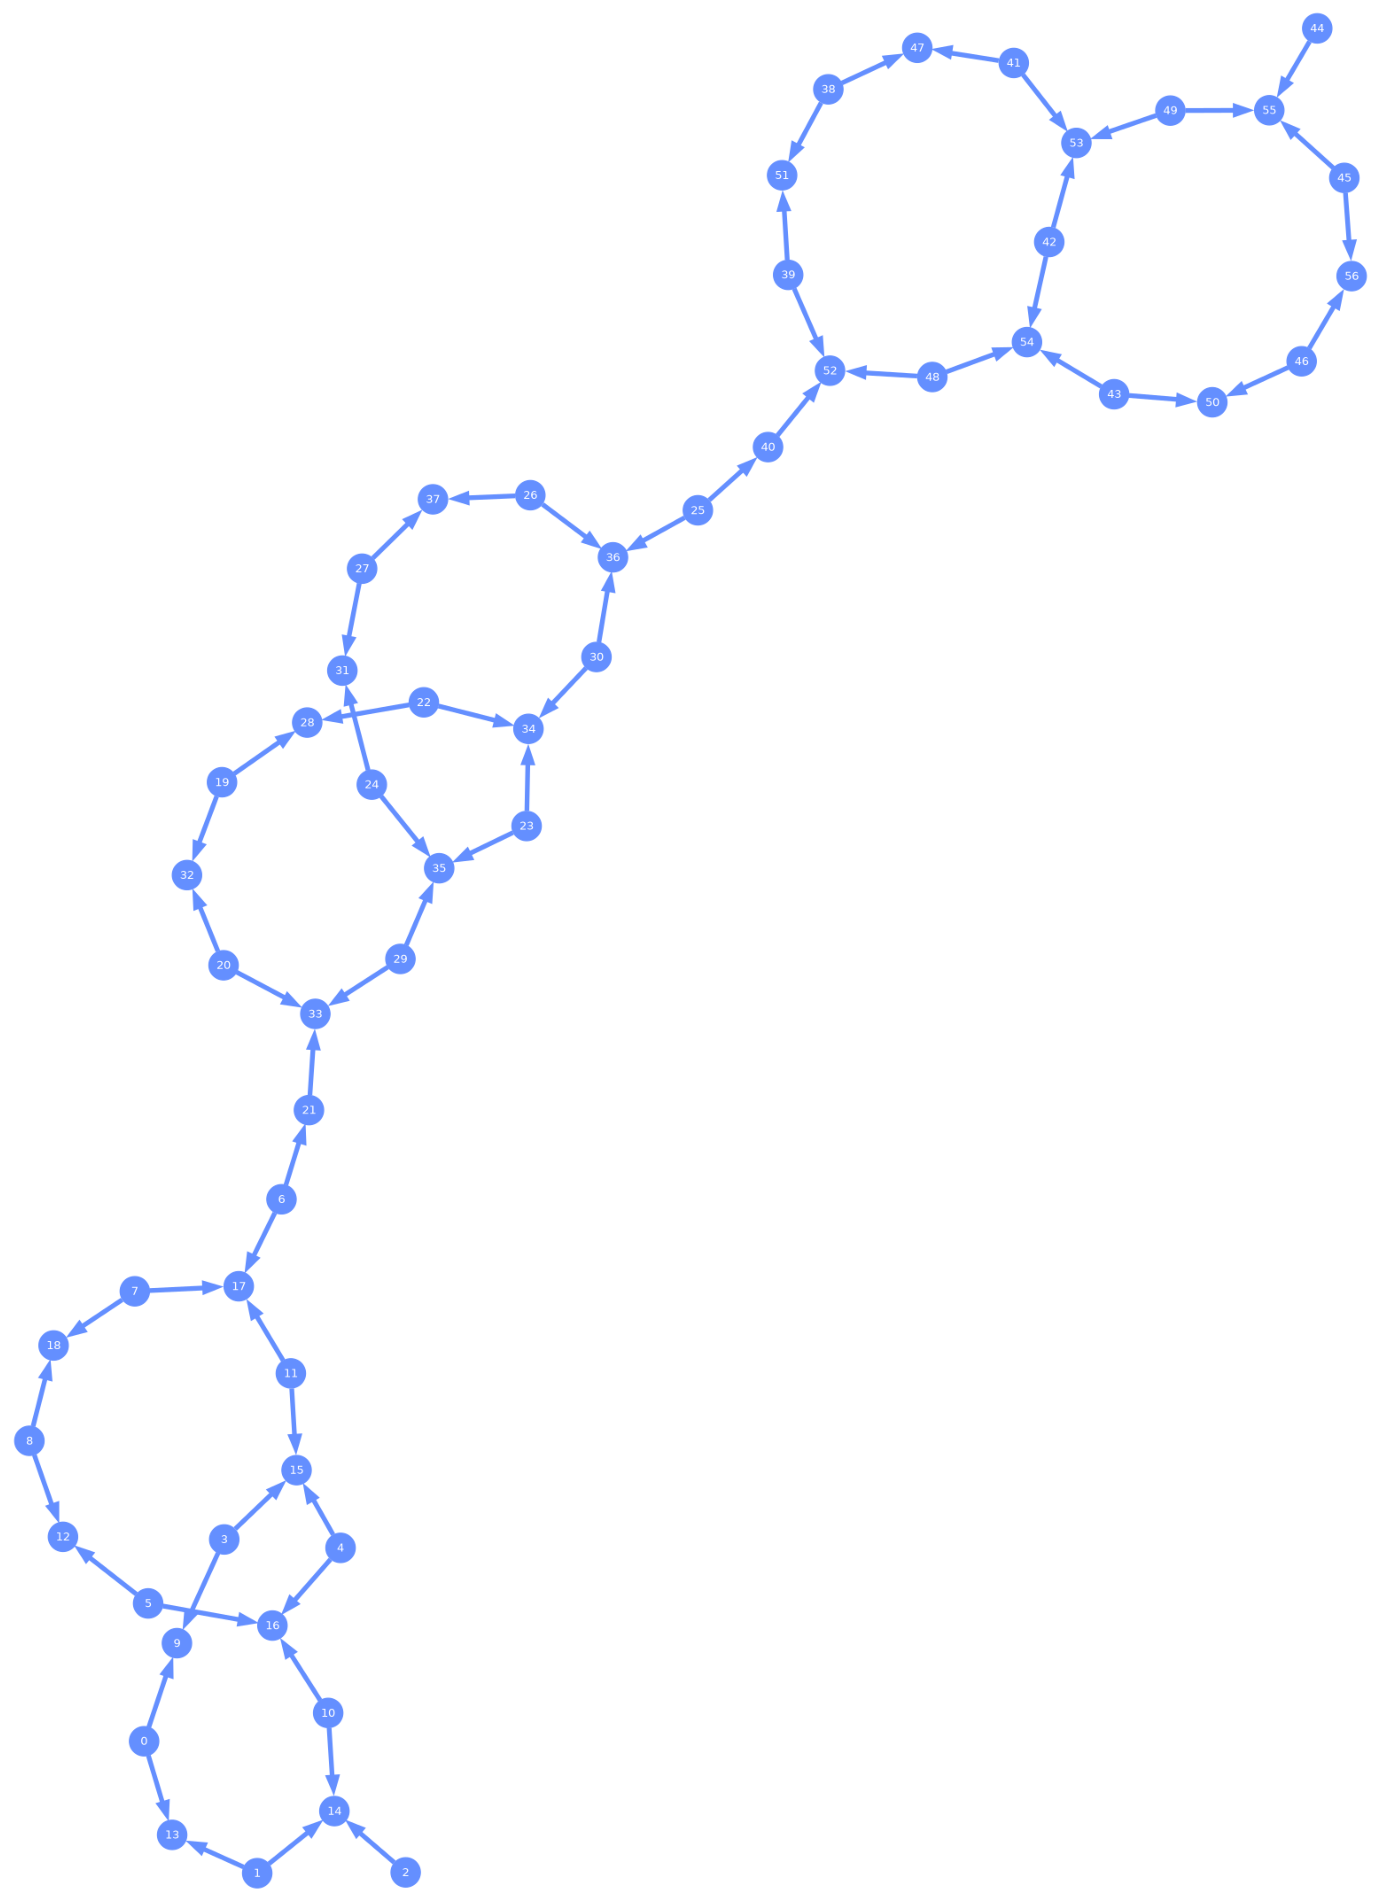

In [17]:
plot_gate_map(backend, plot_directed=True)

In [ ]:
from qiskit import QuantumCircuit, transpile


ghz = QuantumCircuit(backend.num_qubits)
ghz.h(0)
ghz.cx(0, range(1,backend.num_qubits-1))
ghz.measure_all()


In [ ]:
from qiskit.visualization import plot_circuit_layout
# Compile the split ghz circuit
tqc = transpile(ghz, backend)

In [ ]:
plot_circuit_layout(tqc, backend)

In [ ]:
graph = rx.generators.directed_heavy_hex_graph(3, bidirectional=False)
print(graph.node_indices())
print(graph.edge_indices())

In [ ]:
rx.visualization.graphviz_draw(graph)

In [ ]:
node_indices = graph.node_indices()
edge_indices = graph.edge_indices()
orphan_edge = graph.get_edge_endpoints_by_index(edge_indices[0])
edge_list = graph.edge_list()
print(node_indices)
print(edge_indices)

num_edges_dict = {}
for node in node_indices:
    count = 0
    for edge in edge_list:
        if node == edge[0]:
            count+=1
    if count == 1:
        num_edges_dict[node] = count

print(num_edges_dict)


In [ ]:
graph.add_node({
    "color": "green",
    "size": 42,
})
print(graph.node_indices())
print(graph.get_node_data(graph.node_indices()[-1]))
